In [1]:
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

import numpy as np

In [2]:
import kernels as kn
from utils import k_fold_CV
from utils import timed_k_fold_CV

In [3]:
from data.datasets import CannabisGenotype2
from data.datasets import CannabisGenotype

In [46]:
gen = CannabisGenotype2()
X, y = gen.generate()

In [47]:
X.shape

(1324, 13, 2)

In [6]:
def my_kernel_all(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        X1 = np.all(Xi, axis = 2)
        X2 = np.any(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    return G

def my_kernel_any(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        X1 = np.any(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    return G

def smc(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        #  k([a1, a2], [b1, b2]) = a1==b1 and a2==b2
        # compares the whole microsatellite
        X1 = np.all(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    return G

def count(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        #  k([a1, a2], [b1, b2]) = a1==b1 + a2==b2
        X1 = np.sum(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    return G

def count2(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        #  k([a1, a2], [b1, b2]) = a1==b1 + a2==b2
        X1 = np.sum(Xi, axis = 2)/2
        G[i, :] = np.sum(X1, axis=1) / x2
    return G

def k0prime(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        #  k([a1, a2], [b1, b2]) = a1==b1 + a2==b2
        X1 = np.all(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    gamma = 1/4
    return np.exp(gamma * G)

## Nous Kernels

In [62]:
def SMC(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    # Compute the kernel matrix:
    G = np.zeros((xm, ym))
    for i in range(xm):
        Xi = np.tile(X[i], (ym, 1))
        Xi = Xi == Y # prevf
        G[i, :] = (np.sum(Xi, axis=1)/xn)
    return G # postf f(G)


def SMC_creuat(X,Y):
    X = X[0]
    Y = Y[0]
    n = len(X)
    eq = 0
    for i in range(0, n-1, 2):
        eq += (X[i] == Y[i+1]) 
        eq += (Y[i] == X[i+1])
    return eq/n

def compare(array):
    return array[0] == array[1]


def combined(X, Y):
    gamma = 1
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    # Compute the kernel matrix:
    G = np.zeros((x1, y1))
    Ysame = np.apply_along_axis(compare, 2, Y)
    Yrev = np.apply_along_axis(np.flip, 2, Y)
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        # equality kernel
        Xisame = np.apply_along_axis(compare, 2, Xi)
        equality = 2 * np.sum(Xisame == Ysame, axis = 1) / x2
        # crossed SMC
        Xirev = np.apply_along_axis(np.flip, 2, Xi)
        crossedSMC = np.sum(np.all(Xirev==Yrev, axis = 2), axis = 1) / x2
        # Normal kernel or something
        Xi = np.all(Xi == Y, axis = 2)
        k1 = np.sum(Xi, axis=1)
    
        G[i, :] = 0.8 * k1 / x2 + 0.1 * equality + 0.1 * crossedSMC
    return G # postf f(G)

In [63]:
newkernel = svm.SVC(kernel = combined, C = 1)
print(timed_k_fold_CV(newkernel, X, y, 4))

(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
(993,) (993,) (993,)
'timed_k_fold_CV' : 450.51 sec
0.9765861027190332


In [64]:
gram_combined = combined(X,X)

(1324,) (1324,) (1324,)


In [68]:
model_comb = svm.SVC(kernel = gram_combined, C=1, gram = True)
print(timed_k_fold_CV(model_comb, X, y, 4))

TypeError: __init__() got an unexpected keyword argument 'gram'

In [ ]:
def jaccard(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        #  k([a1, a2], [b1, b2]) = a1==b1 + a2==b2 / ()
        X1 = np.all(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    gamma = 1/4
    return np.exp(gamma * G)

In [7]:
mall = svm.SVC(kernel = my_kernel_all, C=1)
many = svm.SVC(kernel = my_kernel_any, C=1)
count_model = svm.SVC(kernel = count, C =1)
cmod2 = svm.SVC(kernel = count2, C =1)
k0 = svm.SVC(kernel = k0prime, C =1)

In [8]:
print(timed_k_fold_CV(mall, X, y, 5))

'timed_k_fold_CV' : 6.09 sec
0.9214951400800458


In [9]:
print(timed_k_fold_CV(count_model, X, y, 5))

'timed_k_fold_CV' : 4.15 sec
0.912438536306461


In [10]:
print(timed_k_fold_CV(cmod2, X, y, 5))

'timed_k_fold_CV' : 4.30 sec
0.9184762721555174


In [11]:
print(timed_k_fold_CV(k0, X, y, 5))

'timed_k_fold_CV' : 4.69 sec
0.9297855917667238


In [65]:
def new_k(X, Y):
    x1, x2, x3 = X.shape
    y1, y2, y3 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1, 1))
        Xi = Xi == Y
        X1 = np.sum(Xi, axis = 2)
        G[i, :] = np.sum(X1, axis=1) / x2
    return G*G

In [66]:
newkernel = svm.SVC(kernel = new_k, C = 1)
print(timed_k_fold_CV(newkernel, X, y, 5))

'timed_k_fold_CV' : 4.18 sec
0.9199885648942253


In [6]:
def simpleMC(X, Y):
    x1, x2 = X.shape
    y1, y2 = Y.shape
    G = np.zeros((x1, y1))
    for i in range(x1):
        Xi = np.tile(X[i], (y1, 1))
        Xi = Xi == Y
        G[i, :] = np.sum(Xi, axis=1) / x2
    return G

In [70]:
simple = svm.SVC(kernel = simpleMC, C = 1/4)
print(timed_k_fold_CV(simple, X, y, 5))

NameError: name 'simpleMC' is not defined

In [15]:
np.tile(4, 2)

array([4, 4])

In [69]:
def optimize_C(my_kernel, X, y, folds, lbound, ubound):
    n = 100
    it = np.tile(lbound, n) + np.array(range((ubound-lbound)*n))/100
    acc = []
    for c in it:
        if c !=0:
            mod = svm.SVC(kernel = my_kernel, C = c)
            acc.append(k_fold_CV(mod, X, y, folds))
        else:
            acc.append(1)
    return np.array(acc), it

In [33]:
acu, iter_ = optimize_C(simpleMC, X, y, 5, 0,10)

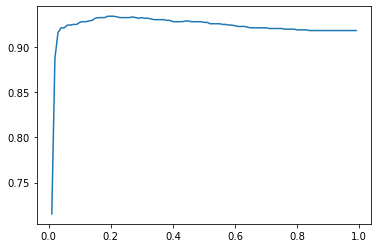

In [37]:
import matplotlib.pyplot as plt

plt.plot(iter_[1:], acu[1:])

In [36]:
np.max(acu[1:])

0.9343224699828474